In [4]:
# Cell Mount Drive and directory setup
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import os, zipfile, shutil

ZIP = '/content/drive/MyDrive/UrbanTripPlanning/snapshots.zip'
EXTRACT_DIR = '/content/snapshots'

if ZIP.endswith('.zip') and not os.path.isdir(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    with zipfile.ZipFile(ZIP, 'r') as zf:
        zf.extractall(EXTRACT_DIR)

contents = os.listdir(EXTRACT_DIR)
if len(contents) == 1 and os.path.isdir(os.path.join(EXTRACT_DIR, contents[0])):
    sub = os.path.join(EXTRACT_DIR, contents[0])
    for name in os.listdir(sub):
        shutil.move(os.path.join(sub, name), EXTRACT_DIR)
    os.rmdir(sub)

SNAPSHOT_DIR = '/content/snapshots'
MODEL_OUT    = '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.pt'
CKPT_OUT     = '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.ckpt'
MAE_CURVE_OUT    = '/content/drive/MyDrive/UrbanTripPlanning/models/mae_curve.png'
RMSE_CURVE_OUT    = '/content/drive/MyDrive/UrbanTripPlanning/models/rmse_curve.png'
SCATTER_OUT =  '/content/drive/MyDrive/UrbanTripPlanning/models/scatter.png'

for path in [MODEL_OUT, CKPT_OUT, MAE_CURVE_OUT, RMSE_CURVE_OUT]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

In [14]:
# Cell 3) Model definition: Multi-task Autoencoder
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.transforms import LineGraph
from torch_geometric.nn import GCNConv, BatchNorm

class EdgeAutoEncoderMultiTask(torch.nn.Module):
    """
    Multi-task GCN autoencoder on line-graph of edges:
      - Encoder: 3 → 64 → 32 → 1 (no ReLU at bottleneck), with residual projections
      - Decoder (feature reconstruction): MLP 1 → 32 → 64 → 3
      - Time-regression head: MLP 1 → 16 → 1
    """
    def __init__(
        self,
        in_ch: int = 3,
        hidden_ch: list = [64, 32],
        bottleneck_ch: int = 1,
        dropout: float = 0.2
    ):
        super().__init__()
        # Encoder conv layers
        self.enc1 = GCNConv(in_ch, hidden_ch[0])
        self.bn1  = BatchNorm(hidden_ch[0])
        self.res1 = torch.nn.Linear(in_ch, hidden_ch[0])      # projection 3→64

        self.enc2 = GCNConv(hidden_ch[0], hidden_ch[1])
        self.bn2  = BatchNorm(hidden_ch[1])
        self.res2 = torch.nn.Linear(hidden_ch[0], hidden_ch[1])# projection 64→32

        self.enc3 = GCNConv(hidden_ch[1], bottleneck_ch)  # no activation

        # Decoder MLP layers for feature reconstruction
        self.dec1 = torch.nn.Linear(bottleneck_ch, hidden_ch[1])
        self.dec2 = torch.nn.Linear(hidden_ch[1], hidden_ch[0])
        self.dec3 = torch.nn.Linear(hidden_ch[0], in_ch)

        # Time-prediction head
        self.time_head = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_ch, 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(16, 1)
        )

        self.dropout = dropout

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index

        # --- Encoder with projected residual + BN + ReLU + Dropout ---
        # Block 1
        res = self.res1(x)                                # [E, 64]
        x = self.enc1(x, edge_index)                     # [E, 64]
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = x + res                                      # [E, 64]

        # Block 2
        res = self.res2(x)                                # [E, 32]
        x = self.enc2(x, edge_index)                     # [E, 32]
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = x + res                                      # [E, 32]

        # Bottleneck (no ReLU)
        z = self.enc3(x, edge_index)      # [E,1]

        # --- Decoder: reconstruct features ---
        d = F.relu(self.dec1(z))          # [E,32]
        d = F.dropout(d, p=self.dropout, training=self.training)
        d = F.relu(self.dec2(d))          # [E,64]
        d = F.dropout(d, p=self.dropout, training=self.training)
        recon = self.dec3(d)              # [E,3]

        # --- Time head: predict travel time ---
        t_pred = self.time_head(z).squeeze(1)  # [E]

        return recon, t_pred, z.squeeze(1)

In [7]:
# Cell 4) Dataset with line-graph transform and temporal split
class InMemoryGraphDataset(Dataset):
    """
    Load all the .pt snapshots into RAM,
    transform each graph to line-graph and set
    x = edge_attr, edge_attr = edge_attr.
    """
    def __init__(self, snapshot_dir: str):
        self.paths = sorted([
            os.path.join(snapshot_dir, fn)
            for fn in os.listdir(snapshot_dir)
            if fn.endswith(".pt")
        ])
        if not self.paths:
            raise RuntimeError(f"No snapshots in {snapshot_dir}")
        print(f"[dataset] Loading {len(self.paths)} snapshots into RAM…")

        self.data_list = []
        lg = LineGraph()  # line-graph transform

        for p in self.paths:
            orig = torch.load(p, weights_only=False)
            L = lg(orig)            # build the line-graph
            # explicitly assigns edge_attr on L
            L.x = orig.edge_attr    # feature per each "node-edge"
            L.edge_attr = orig.edge_attr
            self.data_list.append(L)

        print("[dataset] Loaded all snapshots.")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

def time_based_split(dataset):
    """
    It divides the snapshots into 10 months train, 1 month val, 1 month test.
    """
    dates = []
    pat = re.compile(r"snapshot_[^_]+_(\d{8})T\d{2}\.pt$")
    for p in dataset.paths:
        m = pat.search(p)
        dates.append(datetime.strptime(m.group(1), "%Y%m%d"))
    months = sorted({(d.year, d.month) for d in dates})
    assert len(months) >= 12, "Need at least one year of data!"
    tr_m = months[:10]; va_m = months[10:11]; te_m = months[11:12]
    tr_idx = [i for i,d in enumerate(dates) if (d.year,d.month) in tr_m]
    va_idx = [i for i,d in enumerate(dates) if (d.year,d.month) in va_m]
    te_idx = [i for i,d in enumerate(dates) if (d.year,d.month) in te_m]
    return tr_idx, va_idx, te_idx

In [17]:
# Cell 5) Training routines with AMP, resume/checkpoint, manual interruption, verbose prints
import os
import math
import torch
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader

def train_multitask(
    snapshot_dir: str,
    model_out: str,
    ckpt_out: str,
    epochs: int = 200,
    batch_size: int = 64,
    lr: float = 1e-3,
    lambda_time: float = 1.0,
    patience: int = 20,
    rmse_curve_path: str = None,
    mae_curve_path: str = None,
    scatter_path: str = None
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"▶ Training on {device}\n")

    # Dataset & split
    full_ds = InMemoryGraphDataset(snapshot_dir)
    tr_idx, va_idx, te_idx = time_based_split(full_ds)
    tr_ds, va_ds, te_ds = (
        Subset(full_ds, tr_idx),
        Subset(full_ds, va_idx),
        Subset(full_ds, te_idx),
    )
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # Model, optimizer, losses
    model = EdgeAutoEncoderMultiTask().to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    mse_time = torch.nn.MSELoss()
    mae_time = torch.nn.L1Loss()
    scaler = GradScaler()

    # Try resuming from checkpoint
    start_ep = 1
    best_va = float('inf')
    no_imp = 0
    if os.path.isfile(ckpt_out):
        print(f"↻ Found checkpoint '{ckpt_out}', resuming training...")
        ckpt = torch.load(ckpt_out, map_location=device)
        model.load_state_dict(ckpt['model'])
        optim.load_state_dict(ckpt['optim'])
        start_ep = ckpt.get('epoch', 1) + 1
        best_va = ckpt.get('best_va', best_va)
        no_imp   = ckpt.get('no_imp', no_imp)
        print(f"    Resumed at epoch {start_ep-1}, best_val_MSE={best_va:.6f}, no_imp={no_imp}\n")

    # Containers for curves
    train_time_mse, val_time_mse = [], []
    train_time_rmse, val_time_rmse = [], []
    train_time_mae,  val_time_mae  = [], []

    try:
        for ep in range(start_ep, epochs + 1):
            print(f"\n--- Epoch {ep}/{epochs} ---")
            # Training
            model.train()
            t_mse, t_mae = 0.0, 0.0
            for batch in tr_ld:
                batch = batch.to(device)
                optim.zero_grad()
                with autocast():
                    _, t_pred, _ = model(batch)
                    loss_time_mse = mse_time(t_pred, batch.edge_attr[:,2])
                    loss_time_mae = mae_time(t_pred, batch.edge_attr[:,2])
                    loss = lambda_time * loss_time_mse
                scaler.scale(loss).backward()
                scaler.step(optim)
                scaler.update()
                t_mse += loss_time_mse.item()
                t_mae += loss_time_mae.item()
            avg_tr_mse  = t_mse  / len(tr_ld)
            avg_tr_rmse = math.sqrt(avg_tr_mse)
            avg_tr_mae  = t_mae  / len(tr_ld)
            train_time_mse.append(avg_tr_mse)
            train_time_rmse.append(avg_tr_rmse)
            train_time_mae.append(avg_tr_mae)

            # Validation
            model.eval()
            v_mse, v_mae = 0.0, 0.0
            with torch.no_grad():
                for batch in va_ld:
                    batch = batch.to(device)
                    _, t_pred, _ = model(batch)
                    v_mse += mse_time(t_pred, batch.edge_attr[:,2]).item()
                    v_mae += mae_time(t_pred, batch.edge_attr[:,2]).item()
            avg_va_mse  = v_mse  / len(va_ld)
            avg_va_rmse = math.sqrt(avg_va_mse)
            avg_va_mae  = v_mae  / len(va_ld)
            val_time_mse.append(avg_va_mse)
            val_time_rmse.append(avg_va_rmse)
            val_time_mae.append(avg_va_mae)

            print(f" Train → MSE: {avg_tr_mse:.6f}, RMSE: {avg_tr_rmse:.6f}, MAE: {avg_tr_mae:.6f}")
            print(f" Val   → MSE: {avg_va_mse:.6f}, RMSE: {avg_va_rmse:.6f}, MAE: {avg_va_mae:.6f}")

            # Save checkpoint
            torch.save({
                'epoch':   ep,
                'model':   model.state_dict(),
                'optim':   optim.state_dict(),
                'best_va': best_va,
                'no_imp':  no_imp
            }, ckpt_out)
            print(f" Saved checkpoint to '{ckpt_out}'")

            # Update best
            if avg_va_mse < best_va - 1e-4:
                best_va = avg_va_mse
                no_imp  = 0
                torch.save(model.state_dict(), model_out)
                print(f" ✔ New best model saved to '{model_out}'")
            else:
                no_imp += 1
                print(f" No improvement ({no_imp}/{patience})")

            # Early stopping
            if no_imp >= patience:
                print(f"⏱ Early stopping at epoch {ep}")
                break

    except KeyboardInterrupt:
        print("\n⚠️ Manual interruption detected! Saving current state...")
        torch.save({
            'epoch':   ep,
            'model':   model.state_dict(),
            'optim':   optim.state_dict(),
            'best_va': best_va,
            'no_imp':  no_imp
        }, ckpt_out)
        print(f" Checkpoint after interruption saved to '{ckpt_out}'")
        print(" Exiting training loop early.\n")
        return model

    # Final test
    print("\n▶ Final testing on held-out month")
    model.load_state_dict(torch.load(model_out, map_location=device))
    model.eval()
    te_mse, te_mae = 0.0, 0.0
    true_times, pred_times = [], []
    with torch.no_grad():
        for batch in te_ld:
            batch = batch.to(device)
            _, t_pred, _ = model(batch)
            te_mse += mse_time(t_pred, batch.edge_attr[:,2]).item()
            te_mae += mae_time(t_pred, batch.edge_attr[:,2]).item()
            true_times += batch.edge_attr[:,2].cpu().tolist()
            pred_times += t_pred.cpu().tolist()
    avg_te_mse  = te_mse  / len(te_ld)
    avg_te_rmse = math.sqrt(avg_te_mse)
    avg_te_mae  = te_mae  / len(te_ld)
    print(f" → Test    MSE: {avg_te_mse:.6f}, RMSE: {avg_te_rmse:.6f}, MAE: {avg_te_mae:.6f}")

    # Plotting
    if rmse_curve_path:
        plt.figure(figsize=(8,5))
        plt.plot(train_time_rmse, label='Train RMSE')
        plt.plot(val_time_rmse,   label='Val RMSE')
        plt.xlabel('Epoch'); plt.ylabel('RMSE')
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.savefig(rmse_curve_path)
        print(f" RMSE curve saved to '{rmse_curve_path}'")

    if mae_curve_path:
        plt.figure(figsize=(8,5))
        plt.plot(train_time_mae, label='Train MAE')
        plt.plot(val_time_mae,   label='Val MAE')
        plt.xlabel('Epoch'); plt.ylabel('MAE')
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.savefig(mae_curve_path)
        print(f" MAE curve saved to '{mae_curve_path}'")

    if scatter_path:
        plt.figure(figsize=(6,6))
        plt.scatter(true_times, pred_times, alpha=0.3)
        lims = [min(true_times+pred_times), max(true_times+pred_times)]
        plt.plot(lims, lims, 'r--')
        plt.xlabel('True Time'); plt.ylabel('Predicted Time')
        plt.title('Pred vs True Travel Time')
        plt.grid(True); plt.tight_layout()
        plt.savefig(scatter_path)
        print(f" Scatter plot saved to '{scatter_path}'")

    return model

▶ Training on cuda

[dataset] Loading 8760 snapshots into RAM…
[dataset] Loaded all snapshots.

--- Epoch 1/200 ---


<ipython-input-17-a52cf285ee8b>:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-a52cf285ee8b>:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Train → MSE: 497.875364, RMSE: 22.313121, MAE: 6.923068
 Val   → MSE: 350.252881, RMSE: 18.715044, MAE: 4.766147
 Saved checkpoint to '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.ckpt'
 ✔ New best model saved to '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.pt'

--- Epoch 2/200 ---
 Train → MSE: 371.235778, RMSE: 19.267480, MAE: 5.171167
 Val   → MSE: 340.632820, RMSE: 18.456241, MAE: 4.663702
 Saved checkpoint to '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.ckpt'
 ✔ New best model saved to '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.pt'

--- Epoch 3/200 ---
 Train → MSE: 354.643632, RMSE: 18.831984, MAE: 5.109091
 Val   → MSE: 327.577360, RMSE: 18.099098, MAE: 4.784384
 Saved checkpoint to '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.ckpt'
 ✔ New best model saved to '/content/drive/MyDrive/UrbanTripPlanning/models/edge_autoencoder.pt'

--- Epoch 4/200 ---
 Train → MSE: 334.668582,

EdgeAutoEncoderMultiTask(
  (enc1): GCNConv(3, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res1): Linear(in_features=3, out_features=64, bias=True)
  (enc2): GCNConv(64, 32)
  (bn2): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res2): Linear(in_features=64, out_features=32, bias=True)
  (enc3): GCNConv(32, 1)
  (dec1): Linear(in_features=1, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=3, bias=True)
  (time_head): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

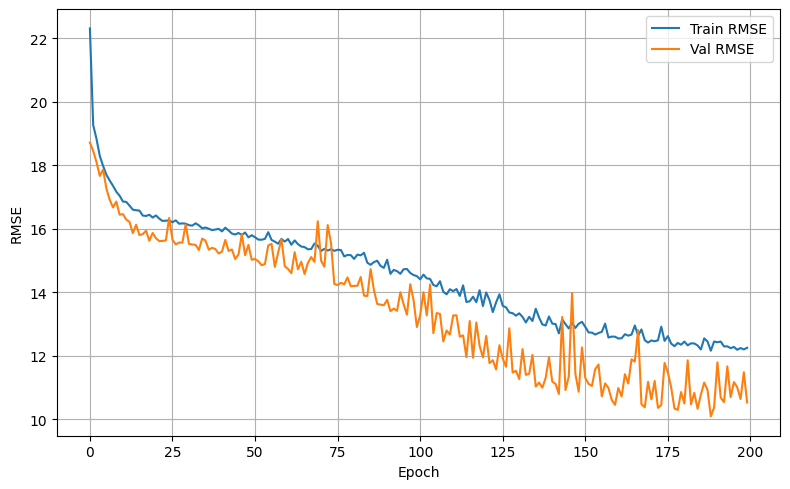

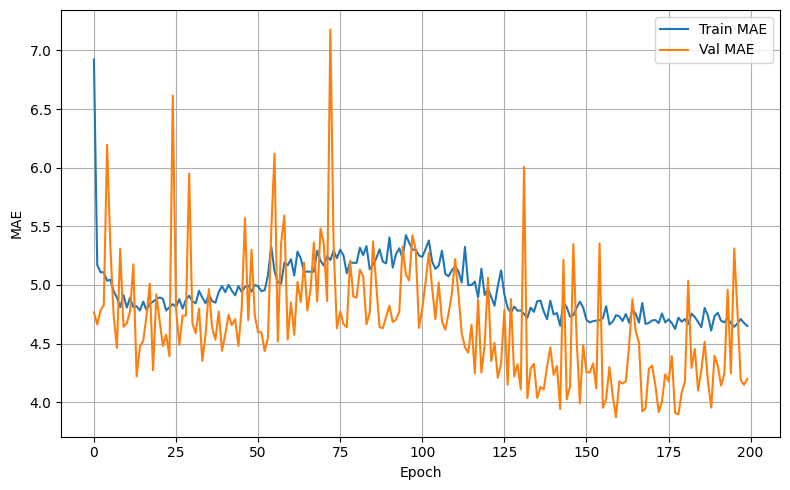

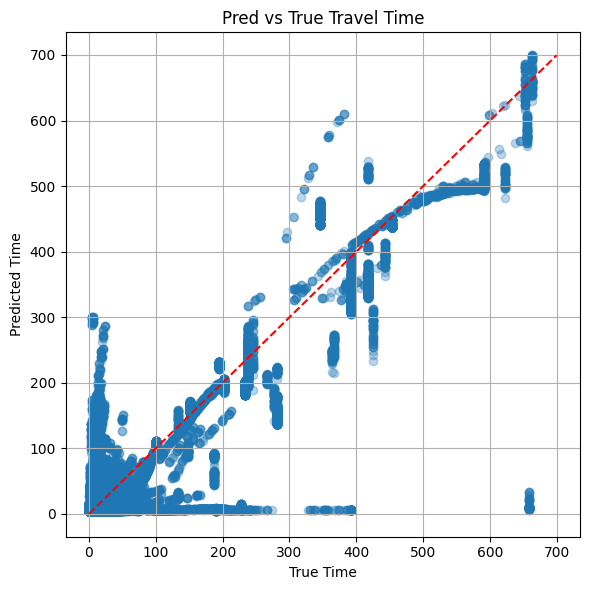

In [18]:
train_multitask(
    snapshot_dir=SNAPSHOT_DIR,
    model_out=MODEL_OUT,
    ckpt_out=CKPT_OUT,
    epochs=200,
    batch_size=64,
    lr=1e-3,
    lambda_time=1.0,
    patience=20,
    rmse_curve_path=RMSE_CURVE_OUT,
    mae_curve_path=MAE_CURVE_OUT,
    scatter_path=SCATTER_OUT
)